In [1]:
import distiller 
import numpy as np
import os, collections
import bitstring 
import time 
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision import datasets, transforms
import torch.nn.functional as F

import models 
from matplotlib import pyplot as plt
# import multiprocessing 
%matplotlib inline

print('using GPU:', torch.cuda.is_available())

/home/hguan2/anaconda2/envs/distiller/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


using GPU: True


In [2]:
test_batch_size = 256
kwargs = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}
test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data.cifar10', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                   ])),
    batch_size=test_batch_size, shuffle=False, **kwargs)

def load_checkpoint(model_path):
    if model_path:
        if os.path.isfile(model_path):
            print("=> loading checkpoint '{}'".format(model_path))
            checkpoint = torch.load(model)
            best_prec1 = checkpoint['best_prec1']
            model.load_state_dict(checkpoint['state_dict'])
            print("=> loaded checkpoint '{}' (epoch {}) Prec1: {:f}"
              .format(model_path, checkpoint['epoch'], best_prec1))
        else:
            raise ValueError("=> no checkpoint found at '{}'".format(model_path))
    else:
        raise ValueError('args.model cannot be empty!')
    return best_prec1 

def test():
    model.eval()
    model.cuda()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            if torch.cuda.is_available():
                data, target = data.cuda(), target.cuda()
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').data # sum up batch loss
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(test_loader.dataset)
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return correct / float(len(test_loader.dataset))

In [3]:
model_path = "/home/hguan2/workspace/fault-tolerance/rethinking-network-pruning/cifar/l1-norm-pruning"+ \
    "/logs/vgg16/cifar10/model_best.pth.tar"
arch = 'vgg'
depth = '16'
dataset = 'cifar10'

checkpoint = torch.load(model_path)
model = models.__dict__[arch](dataset=dataset, depth=depth, cfg=checkpoint['cfg'])
model.load_state_dict(checkpoint['state_dict'])
best_prec1 = checkpoint['best_prec1']
print("=> loaded checkpoint '{}' (epoch {}) Prec1: {:f}"
              .format(model_path, checkpoint['epoch'], best_prec1))
# print(model)

=> loaded checkpoint '/home/hguan2/workspace/fault-tolerance/rethinking-network-pruning/cifar/l1-norm-pruning/logs/vgg16/cifar10/model_best.pth.tar' (epoch 158) Prec1: 0.938800


In [4]:
from eval_util import test_cifar10
prec1 = test_cifar10(model)

 * Acc@1 93.880 Acc@5 99.620


In [101]:
model_size = 0 
for name, param in model.named_parameters():
    print(name, param.data.size())
    model_size += param.data.nelement()
print('model size:', model_size)

feature.0.weight torch.Size([64, 3, 3, 3])
feature.1.weight torch.Size([64])
feature.1.bias torch.Size([64])
feature.3.weight torch.Size([64, 64, 3, 3])
feature.4.weight torch.Size([64])
feature.4.bias torch.Size([64])
feature.7.weight torch.Size([128, 64, 3, 3])
feature.8.weight torch.Size([128])
feature.8.bias torch.Size([128])
feature.10.weight torch.Size([128, 128, 3, 3])
feature.11.weight torch.Size([128])
feature.11.bias torch.Size([128])
feature.14.weight torch.Size([256, 128, 3, 3])
feature.15.weight torch.Size([256])
feature.15.bias torch.Size([256])
feature.17.weight torch.Size([256, 256, 3, 3])
feature.18.weight torch.Size([256])
feature.18.bias torch.Size([256])
feature.20.weight torch.Size([256, 256, 3, 3])
feature.21.weight torch.Size([256])
feature.21.bias torch.Size([256])
feature.24.weight torch.Size([512, 256, 3, 3])
feature.25.weight torch.Size([512])
feature.25.bias torch.Size([512])
feature.27.weight torch.Size([512, 512, 3, 3])
feature.28.weight torch.Size([512])


In [5]:
# post train quantization 
quantizer = distiller.quantization.PostTrainLinearQuantizer(model)
quantizer.prepare_model()

In [6]:
# prec1 = test()
# from eval_util import test_cifar10
prec1 = test_cifar10(model)

 * Acc@1 93.760 Acc@5 99.610


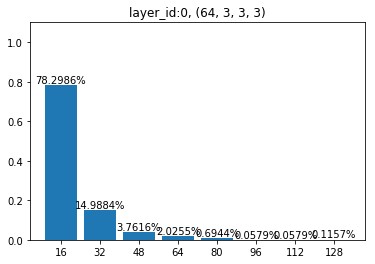

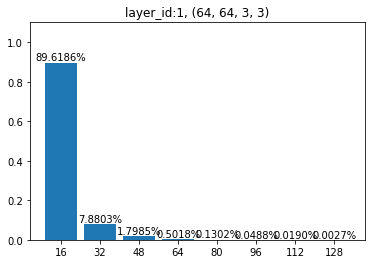

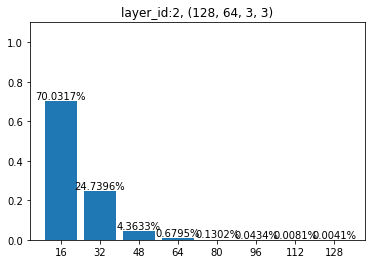

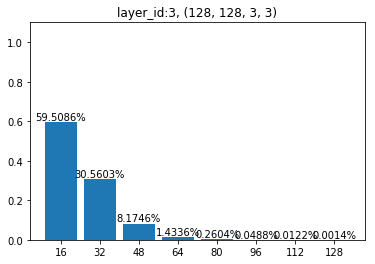

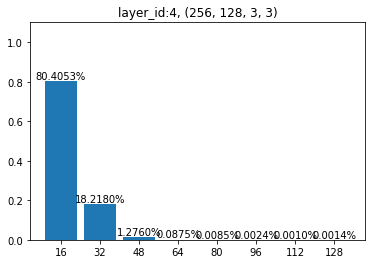

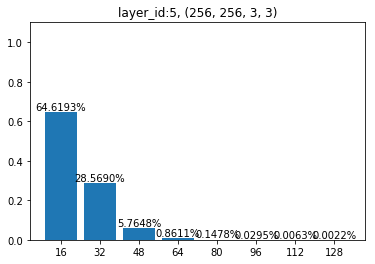

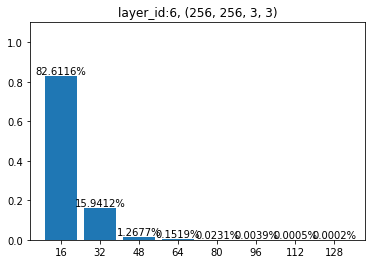

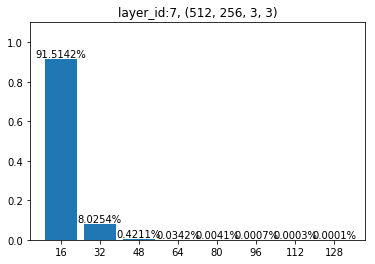

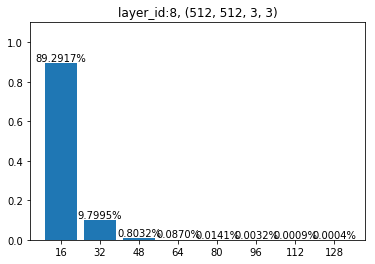

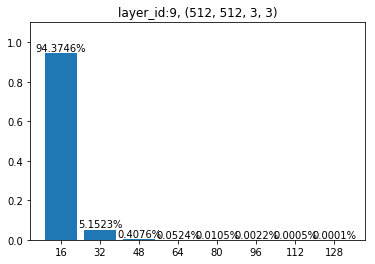

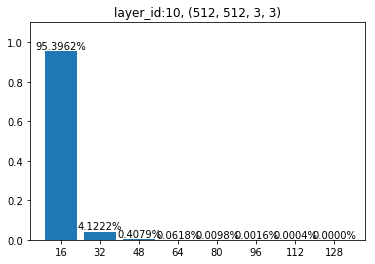

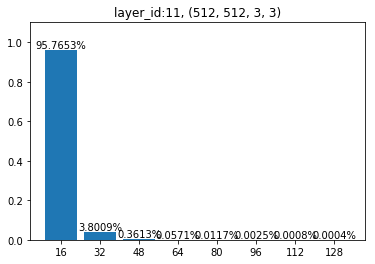

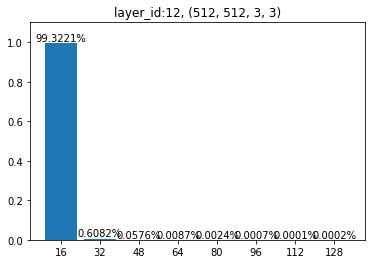

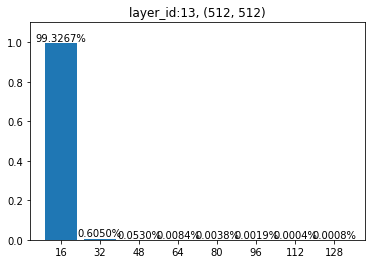

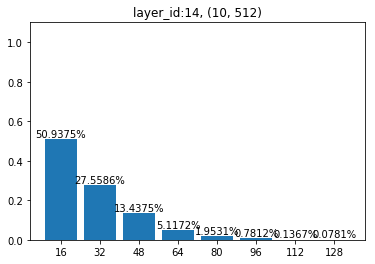

In [130]:
# check the distribution of parameters 
thr = 16
layer_id = 0 
for param_name, param in model.named_parameters():
    if len(param.size()) < 2:
        continue
    counter = collections.Counter(np.abs(param.data.cpu().numpy().ravel())//thr)
    tmp = sorted(counter.items(), key=lambda x: x[0])
    values, counts = zip(*tmp)
    percentages = [count/sum(list(counts)) for count in counts]
    bar = plt.bar(values, percentages)
    for rect in bar:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.4f%%' %(height*100), ha='center', va='bottom')
#     print(['%.2f' %(p) for p in percentages])
    #plt.hist(param.data.cpu().numpy().ravel(), bins=10, density=True)
    plt.xticks(values, [str(int(v)*thr+thr) for v in values])
    plt.title('layer_id:'+str(layer_id) + ', '+ str(tuple(param.size())))
#     plt.grid()
    plt.ylim(0, 1.1)
    plt.show()
    layer_id += 1

In [ ]:
# Date: 2019/04/18 
# check smart bit copy
# when |v| < 32, the second and third bits are not informative. Can be used to make a copy of other bits
# when |v| >= 32, assume the last 1/2 bits are not informative? This is lossy encoding. 

# strategy 1: use the lossless encoding to only protect |v| < 32; use an extra bit 8/1 to indicate
#             whether encoding is applied or not. 
# strategy 2: use the lossless encoding to protect |v| < 32, use the lossy encoding to protect |v| > 32. 



In [51]:
# check bit copy model-wise 

# def get_copy_bits_fn(n_LSB=1):
#     assert 0 < n_LSB < 5 
#     print('Copy n_LSB:', n_LSB)
#     def copy_bits(v):
#         bits = bitstring.pack('>b', v)
#         # print('befor, bits:', bits.bin, bits.int)
#         bits[8-n_LSB:8] = bits[:n_LSB]
#         # print('after, bits:', bits.bin, bits.int)
#         return bits.int
#     return copy_bits 
    

# for n_LSB in [1, 2, 3]:
#     copy_bits = get_copy_bits_fn(n_LSB)

#     start = time.time()
#     for name, param in model.named_parameters():
#         if len(param.size()) < 2:
#             continue
#         tensor = param.data.cpu()
#         tensor_shape = tensor.size()
#         tensor_1d = tensor.numpy().ravel()
#     #     print('befor:', tensor_1d)
#         tensor_1d = np.asarray([copy_bits(v) for v in tensor_1d], dtype='float32')
#         #print('after:', tensor_1d)
#         param.data = torch.from_numpy(np.reshape(tensor_1d, tensor_shape))
#         #print('after:', param.data.view(-1))
#         print('Finish parameter:', name, str(param.size()))
#     end = time.time
#     print("elapsed time: %f(min)" %((end-start)/60))
#     # test accuracy
#     prec1 = test()



In [52]:
# check bit copy per layer 

def get_copy_bits_fn(n_LSB=1):
    assert 0 < n_LSB < 5 
#     print('Copy n_LSB:', n_LSB)
    def copy_bits(v):
        bits = bitstring.pack('>b', v)
        # print('befor, bits:', bits.bin, bits.int)
        bits[8-n_LSB:8] = bits[:n_LSB]
        # print('after, bits:', bits.bin, bits.int)
        return bits.int
    return copy_bits 

def write_log(info, mode='a'):
    with open('./tmp/check_quantized_bit_copy_layerwise.txt', mode) as f:
        f.write(info+'\n')
        
info = "%s\t %s\t %s\t %s\t %s\t" %("name", "tensor_shape", "n_LSB", "prec1", "total_time")
write_log(info, mode='w')

for name, param in model.named_parameters():
    if len(param.size()) < 2:
        continue
    
    tensor_copy = param.data.clone() 
    tensor_shape = param.data.size()
    
    
    for n_LSB in [1, 2, 3, 4]:
        start = time.time()
        
        copy_bits = get_copy_bits_fn(n_LSB)
        tensor_1d = param.data.cpu().numpy().ravel()
        # print('befor:', tensor_1d)
        tensor_1d = np.asarray([copy_bits(v) for v in tensor_1d], dtype='float32')
        # print('after:', tensor_1d)
        param.data = torch.from_numpy(np.reshape(tensor_1d, tensor_shape))
        # print('after:', param.data.view(-1))
        
        # test accuracy
        prec1 = test()
        
        # recover the param
        param.data = tensor_copy
    
        end = time.time()
        total_time = (end-start)/60
        info = "%s\t %s\t %s\t %s\t %s\t" %(name, tuple(tensor_shape), n_LSB, prec1, total_time)
        print(info)
        write_log(info)

    


Test set: Average loss: 0.3166, Accuracy: 9382/10000 (93.82%)
feature.0.wrapped_module.weight	 (64, 3, 3, 3)	 1	 0.9382	 0.043767849604288735	
Test set: Average loss: 0.3220, Accuracy: 9358/10000 (93.58%)
feature.0.wrapped_module.weight	 (64, 3, 3, 3)	 2	 0.9358	 0.04476538896560669	
Test set: Average loss: 0.3367, Accuracy: 9320/10000 (93.20%)
feature.0.wrapped_module.weight	 (64, 3, 3, 3)	 3	 0.932	 0.04483282168706258	
Test set: Average loss: 0.4415, Accuracy: 9098/10000 (90.98%)
feature.0.wrapped_module.weight	 (64, 3, 3, 3)	 4	 0.9098	 0.043702284495035805	
Test set: Average loss: 0.3171, Accuracy: 9375/10000 (93.75%)
feature.3.wrapped_module.weight	 (64, 64, 3, 3)	 1	 0.9375	 0.10916215976079305	
Test set: Average loss: 0.3291, Accuracy: 9355/10000 (93.55%)
feature.3.wrapped_module.weight	 (64, 64, 3, 3)	 2	 0.9355	 0.11194942394892375	
Test set: Average loss: 0.4153, Accuracy: 9162/10000 (91.62%)
feature.3.wrapped_module.weight	 (64, 64, 3, 3)	 3	 0.9162	 0.1102660576502482	
Tes

Test set: Average loss: 0.2946, Accuracy: 9374/10000 (93.74%)
classifier.3.wrapped_module.weight	 (10, 512)	 3	 0.9374	 0.053039737542470294	
Test set: Average loss: 0.2723, Accuracy: 9378/10000 (93.78%)
classifier.3.wrapped_module.weight	 (10, 512)	 4	 0.9378	 0.0491856853167216	


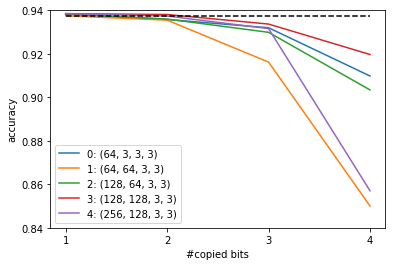

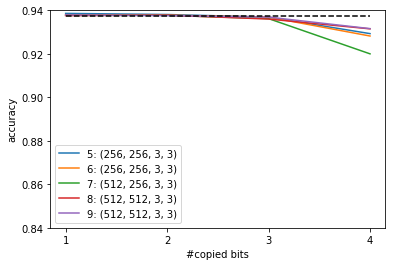

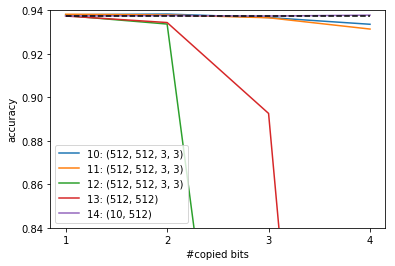

In [72]:
def read_log():
    data = [] 
    with open('./tmp/check_quantized_bit_copy_layerwise.txt', 'r') as f:
        lines = f.readlines()
        for line in lines[1:]:

            name, tensor_shape, n_LSB, prec1, *arg = line.split('\t')
            n_LSB, prec1 = int(n_LSB), float(prec1)
            if data and data[-1]["name"] == name:
                data[-1]["res"].append((n_LSB, prec1))
            else:
                data.append({'name': name, 'tensor_shape': tensor_shape, 'res': [(n_LSB, prec1)]})
    return data 
results = read_log()

for i in range(len(results)):
    n_LSBs, accuracies = zip(*results[i]['res'])
    plt.plot(n_LSBs, accuracies, label=str(i)+':'+results[i]["tensor_shape"])
    if (i+1)%5 == 0 or i == len(results)-1:
        plt.legend()
        plt.plot(n_LSBs, [0.9375]*len(n_LSBs), 'k--')
        plt.ylim(0.84, 0.94)
        plt.xlabel('#copied bits')
        plt.ylabel('accuracy')
        plt.xticks(n_LSBs, [str(x) for x in n_LSBs])
        plt.show()
            
                
            

feature.0.wrapped_module.weight torch.Size([64, 3, 3, 3])


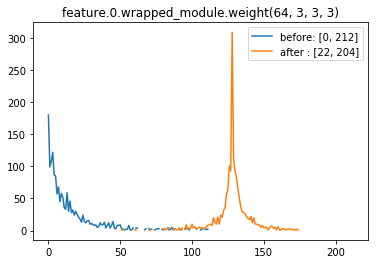

feature.3.wrapped_module.weight torch.Size([64, 64, 3, 3])


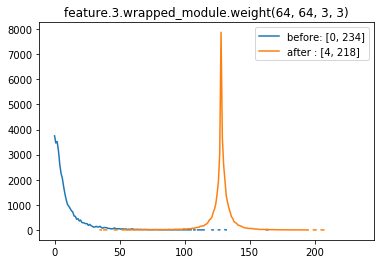

feature.7.wrapped_module.weight torch.Size([128, 64, 3, 3])


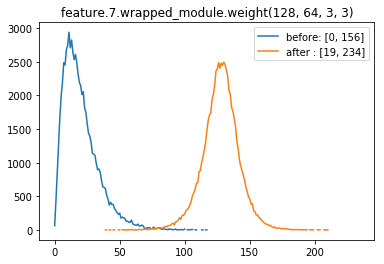

feature.10.wrapped_module.weight torch.Size([128, 128, 3, 3])


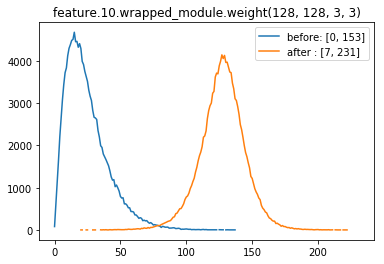

feature.14.wrapped_module.weight torch.Size([256, 128, 3, 3])


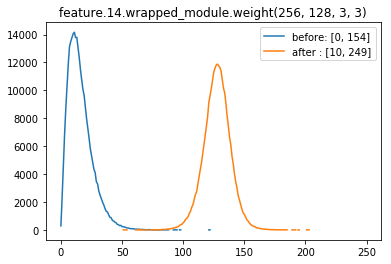

feature.17.wrapped_module.weight torch.Size([256, 256, 3, 3])


KeyboardInterrupt: 

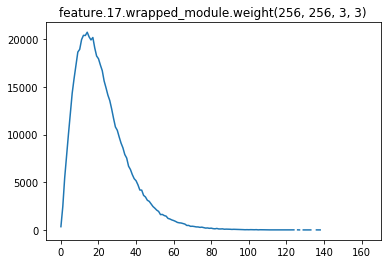

In [11]:
# check locality 

def flip_one_bit(bit_position):
    assert 0 <= bit_position <= 7
    def helper1(v):
        bits = bitstring.pack('>b', v)
        bits[bit_position] ^= 1
        return bits.int 
    def helper2(v):
        offset = [128, 64, 32, 16][bit_position]
        if v < 0:
            v = v + offset 
        else:
            v = v - offset 
        return v 
    return helper1, helper2 

bit_position = 0
_, flip = flip_one_bit(bit_position)
# print(flip1(-128), flip2(-128))

# w1, w2, w3; locality(w2) = max(|w2-w1|, |w2-w3|)
for name, param in model.named_parameters():
    
    # only consider weights 
    if len(param.size()) < 2:
        continue 
    print(name, param.size())
    tensor_1d = param.data.cpu().numpy().ravel()
    left = np.concatenate((tensor_1d[:1], tensor_1d[:-1]), axis=0)
    right = np.concatenate((tensor_1d[1:], tensor_1d[-1:]), axis=0)
    locality = collections.Counter(np.maximum(np.abs(tensor_1d - left), np.abs(tensor_1d - right)))

    diffs = locality.keys()
    plt.plot(range(256), [locality.get(x) for x in range(256)], 
             label='before: [%d, %d]' %(min(diffs), max(diffs)))
#     plt.ylim(0, 256)
    plt.title(name + str(tuple(param.size())))

    
    # after sign bit flipped
    tensor_1d_flipped = np.array([flip(v) for v in tensor_1d])
    locality = collections.Counter(np.maximum(np.abs(tensor_1d_flipped - left), np.abs(tensor_1d_flipped - right)))
    diffs = locality.keys()
    plt.plot(range(256), [locality.get(x) for x in range(256)], 
             label='after : [%d, %d]' %(min(diffs), max(diffs)))
#     plt.title('flip bit_pos:'+ str(bit_position)) 
#     plt.ylim(0, 256)
    plt.legend()
    plt.show()

    
    

In [54]:
# check data reorganization 
bit_counter = [[] for _ in range(8)]
value_count = 0 
start = time.time()
for name, param in model.named_parameters():
    # ignore batch normalization layer 
    if len(param.data.size()) < 2:
        continue 
    tensor = param.data.cpu().numpy().ravel()
    value_count += len(tensor)
    for v in tensor:
        bits = bitstring.pack('>b', v)
        for i in range(8):
            bit_counter[i] += bits[i],
    print('Finish parameter:', name, str(param.size()))
end = time.time()
print('Elasped in: %s(s)' %(end-start))
print('value_count:', value_count)

Finish parameter: feature.0.wrapped_module.weight torch.Size([64, 3, 3, 3])
Finish parameter: feature.3.wrapped_module.weight torch.Size([64, 64, 3, 3])
Finish parameter: feature.7.wrapped_module.weight torch.Size([128, 64, 3, 3])
Finish parameter: feature.10.wrapped_module.weight torch.Size([128, 128, 3, 3])
Finish parameter: feature.14.wrapped_module.weight torch.Size([256, 128, 3, 3])
Finish parameter: feature.17.wrapped_module.weight torch.Size([256, 256, 3, 3])
Finish parameter: feature.20.wrapped_module.weight torch.Size([256, 256, 3, 3])
Finish parameter: feature.24.wrapped_module.weight torch.Size([512, 256, 3, 3])
Finish parameter: feature.27.wrapped_module.weight torch.Size([512, 512, 3, 3])
Finish parameter: feature.30.wrapped_module.weight torch.Size([512, 512, 3, 3])
Finish parameter: feature.34.wrapped_module.weight torch.Size([512, 512, 3, 3])
Finish parameter: feature.37.wrapped_module.weight torch.Size([512, 512, 3, 3])
Finish parameter: feature.40.wrapped_module.weigh

Text(0,0.5,'1 count')

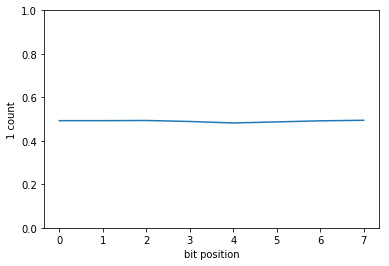

In [53]:
plt.plot([x*1.0/value_count for x in bit_counter])
plt.ylim(0, 1)
plt.xlabel('bit position')
plt.ylabel('1 count')

In [115]:
# for key, value in model.state_dict().items():
#     print(key, value)

In [114]:
# save_path = os.path.join("/".join(model_path.split('/')[:-1]), 'quantize') 
# if not os.path.exists(save_path):
#     os.makedirs(save_path)
    
# # save accuracy
# with open(os.path.join(save_path, "quantize.txt"), "w") as fp:
#     fp.write("Test accuracy: \n"+str(prec1)+"\n")

# # save quantized model     
# torch.save({ 'cfg': model.cfg, 
#             'state_dict': model.state_dict(), 
#             'prec1': prec1
#            }, os.path.join(save_path, 'quantized.pth.tar'))

In [113]:
# check the weight distribution of other pre-trained models in torch vision
# import torchvision 

# pretrained_models = {'resnet18': torchvision.models.resnet18(pretrained=True),
#                      'alexnet': torchvision.models.alexnet(pretrained=True),
#                      'squeezenet': torchvision.models.squeezenet1_0(pretrained=True),
#                      'vgg16':  torchvision.models.vgg16(pretrained=True), 
#                      'densenet':  torchvision.models.densenet161(pretrained=True),
#                      'inception_v3':  torchvision.models.inception_v3(pretrained=True),
#                     }
# for model_name, pretrained_model in pretrained_models.items():
#     tensor = [param.data.cpu().numpy().ravel() for param in pretrained_model.parameters()]
#     tensor = np.concatenate(tensor)
#     minv, maxv = np.min(tensor), np.max(tensor)
#     num_values = tensor.shape[0]
#     plt.hist(tensor, bins=10000)
#     plt.title(model_name+ ':[%f, %f], #=%.1f(M)' %(minv, maxv, num_values/10e6))
#     plt.show()